<a href="https://colab.research.google.com/github/georgeaidinis/NTUA/blob/master/NN/Lab%202/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
Ημερομηνία εκφώνησης άσκησης: 8/12/19
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 



In [2]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)
Requirement already up-to-date: joblib in /usr/local/lib/python3.6/dist-packages (0.14.1)


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [0]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα μπορεί να βρει [εδώ](https://docs.google.com/spreadsheets/d/1oEr3yuPg22lmMeqDjFtWjJRzmGQ8N57YIuV-ZOvy3dM/edit?usp=sharing) τον μοναδικό  αριθμό της "Seed" από 1 έως 78. 

2. Το data frame `df_data_2` έχει 78 γραμμές (ομάδες) και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας από το Google Sheet.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [0]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 23

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string), list of 5000
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string), list of 5000
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category), array of 5000*322
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [9]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Chick Magnet']
['"Romantic comedy",  "Romance Film",  "Comedy",  "Comedy film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf. <br> Ο TfidfVectorizer συνδυάζει τα μοντέλα CountVectorizer και TfidfTransformer. Ο πρώτος εφαρμόζει tokenization και βρίσκει τις εμφανίσεις κάθε λέξης σε κάθε κείμενο του corpus, δηλαδή σε κάθε κριτική. Ο δεύτερος υπολογίζει τους tf-idf συντελεστές.<br>
Δεν λαμβάνονται υπόψην λέξεις που:
* δεν προσθέτουν νέα πληροφορία λόγω της εμφάνισής τους σε πολλά αγγλικά κείμενα (stop words)
* εμφανίζονται ποσοστό των κειμένων του corpus μεγαλύτερο του x (max_df)
* εμφανίζονται σε λιγότερα κείμενα από y (min_df)


Αλλάζουμε τις παραμέτρους δίνοντάς μας τη δυνατότητα να προσθέσουμε και δικιές μας stopwords.

In [0]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_english
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(mx_df, mn_df, my_stopwrods=list()):

  stopwords_film = ["movie", "film", "plot", "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping"]
  stopwords = list(stopwords_english) + list(my_stopwrods) + list(stopwords_film)# enhancing stopwords

  vectorizer = TfidfVectorizer(max_df=mx_df, min_df=mn_df, stop_words=stopwords, analyzer='word')
  vectorizer.fit(corpus)
  corpus_tf_idf = vectorizer.transform(corpus)
  print("Dimensions: ", corpus_tf_idf.shape, "\n")


  return corpus_tf_idf

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing) των ασκήσεων.


In [12]:
print(tf_idf(1.0, 0))

Dimensions:  (5000, 48259) 

  (0, 40124)	0.21238465458574116
  (0, 39464)	0.13351976687936476
  (0, 35971)	0.14615800861628445
  (0, 34587)	0.5789705755549767
  (0, 33502)	0.18037842247252975
  (0, 32638)	0.19705388864626128
  (0, 27935)	0.3238774441811171
  (0, 23987)	0.4872240039741379
  (0, 17918)	0.09922598819785111
  (0, 16542)	0.23676633227404953
  (0, 16405)	0.2104218843363792
  (0, 7736)	0.23804251310562874
  (1, 47902)	0.01423446731727961
  (1, 47802)	0.0159759637184735
  (1, 47603)	0.02927745942024364
  (1, 47601)	0.056512661619941985
  (1, 47595)	0.07880768817412807
  (1, 47519)	0.03543301973938139
  (1, 47506)	0.037654407714266945
  (1, 47504)	0.03506671805545417
  (1, 47480)	0.033969809026154
  (1, 47449)	0.027699709952391828
  (1, 47419)	0.025933547469626096
  (1, 47143)	0.015094840668391412
  (1, 46827)	0.026012023883060488
  :	:
  (4999, 25221)	0.07182670346256194
  (4999, 24998)	0.098165486502305
  (4999, 24418)	0.0788913580998555
  (4999, 23583)	0.060799482581889545


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [0]:
# function that prints movie info
def print_movie(ID):
  print("ID: ", ID)
  print("Title: ", ', '.join(titles[ID]))
  print("Categories: ", ', '.join(categories[ID]))
  print("Summary:\n", corpus[ID], "\n")

In [0]:
from sklearn.metrics.pairwise import linear_kernel

def content_recommender(ID, max_recommendations):
  cosine_similarities = linear_kernel(corpus_tf_idf[ID], corpus_tf_idf).flatten()  # calculating cosine similarities using sparse matrices

  cosine_similarities = (-cosine_similarities).argsort()  # sorting the array and saving movies based on ID's

  print_movie(ID)  # print target movie info

  for i in range(1, max_recommendations+1):   # print recommendations
    print("Place:", i)
    print_movie(cosine_similarities[i])

Ένα παράδειγμα χρήσης για την 2η ταινία και 5 recommendations:

In [15]:
corpus_tf_idf = tf_idf(1.0, 0)

Dimensions:  (5000, 48259) 



In [16]:
content_recommender(1, 5)

ID:  1
Title:  The Nines
Categories:  "Science Fiction",  "Comedy-drama",  "Mystery",  "Drama",  "Fantasy Drama",  "Fantasy"
Summary:
 "Part One: The Prisoner" tells of a troubled actor, Gary , who is wearing a green bracelet on his wrist. Gary is under house arrest living in another person's house because he burned down his own. The owner of the house is described as a TV writer away on work. While living in the house he is befriended by both a P.R. 'handler', Margaret , and the single mom next door, Sarah , who may or may not be interested in him romantically. Over the course of his house arrest, Gary becomes convinced that he is being haunted by the number nine, including finding a note saying "Look for the nines" in his handwriting. He encounters many occurrences of the number nine, while playing backgammon he rolls nines, while reading newspaper advertisements he becomes obsessed with finding nines. Asking Sarah about the number 9 worries her and she cryptically tells him "I can g

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 

------------------------------------------------------------------------------


Ορίζουμε την συνάρτηση similar_movies οι οποία μας επιστρέφει το σύνολο των ταινιών στόχων, για τις οποίες οι πρώτες 3 επιλογές ανήκαν σε count (count είναι η παράμετρος που της δίνουμε) είδη όμοια με την πρώτη. Εκτός των υπολοίπων μεθόδων συμβουλευόμαστε και αυτήν την μετρική και με τη μεγιστοποίηση της συνάρτησης αυτής προσπαθούμε να βελτιστοποιήσουμε τον Tfidfvectorizer.

In [0]:
def similar_movies(count):
  movie_list = []

  for i in range(0, 5000): # for all movies
    cnt = count

    cosine_similarities = linear_kernel(corpus_tf_idf[i], corpus_tf_idf).flatten()  # find best matches
    cosine_similarities = (-cosine_similarities).argsort()
    
    categs = categories[i][0]
    categs = categs.split(",")
    
    for category in categs: # find categories similar between th movie and the 3 top matches
      if category.lstrip(' ') in (categories[cosine_similarities[1]][0]) and category.lstrip(' ') in (categories[cosine_similarities[2]][0]) and category.lstrip(' ') in (categories[cosine_similarities[3]][0]):
        cnt = cnt - 1
      if cnt == 0: # if count similar categories are found append the movie to movie_list
        movie_list.append(i)
        break

  return movie_list

Εμπλουτίζουμε τις stop words με αγγλικά ονόματα. Έτσι οι ομοιότητες μεταξύ ταινιών δεν θα οφείλονται σε κοινά ονόματα χαρακτήρων τους. Εξηγούμε παρακάτω γιατί προέκυψε η ανάγκη πρόσθεσής τους.

In [0]:
import urllib.request 
import string

# female english names
target_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt"
response = urllib.request.urlopen(target_url).read().decode()
lines_temp = response.split('\n')
names = []

for line in lines_temp:
  if line and line[0] != "#":
    names.append(line.lower())

# male english names
target_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt"
response = urllib.request.urlopen(target_url).read().decode()
lines_temp = response.split('\n')

for line in lines_temp:
  if line and line[0] != "#":
    names.append(line.lower())


Παρατηρούμε μείωση στη διαστατικότητα κατά 3000 περίπου. Δηλαδή έφυγαν 3000 ονόματα που αναφέρονταν στους πρωταγωνιστές των ταινιών.

In [19]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 45239) 



## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

-------------------------------------------------------------------------------

Αρχικά παρατηρήσαμε πως σε πολλές περιπτώσεις οι παρόμοιες ταινίες οφείλονταν σε κοινά ονόματα χαρακτήρων τους. Έτσι ενισχύσαμε τις stopwords με αγγλικά ονόματα ώστε να μην εντοπίζονται αυτές οι ομοιότητες. 


In [20]:
corpus_tf_idf = tf_idf(1.0, 0)

Dimensions:  (5000, 48259) 



Παρακάτω φαίνεται το πρόβλημα που δημιουργείται εξαιτίας των ονομάτων. Όπως φαίνεται ο πρωταγωνιστής της ταινία στόχου ονομάζεται Ben. Επειδή το όνομα λαμβάνεται υπόψην ως λέξη παρατηρούμε οτι και οι 3 πρώτες ταινίες περιέχουν επίσης αυτό το όνομα. Αυτό σημαίνει οτι ίσως να υπάρχουν σχετικότερες ταινίες με την ταινία στόχο, οι οποίες να υποβαθμίζονται λόγω αυτών των ομοιοτήτων.

In [21]:
content_recommender(10, 3)

ID:  10
Title:  Cashback
Categories:  "Romance Film",  "Drama",  "Comedy"
Summary:
 Ben, an aspiring artist, develops insomnia after a painful breakup with his girlfriend, Suzy. To take his mind off of Suzy and to occupy the extra waking hours he has recently gained, Ben begins working at a local Sainsbury's supermarket, where he meets colourful co-workers. Among them is his colleague Sharon, with whom he soon develops a mutual crush. As his personal means to escape the boredom inherent in the night shift, Ben lets his imagination run wild. In particular, he imagines that he can stop time so that he can walk around in a world that is "frozen" like the pause of a film. He imagines female patrons of the supermarket stopped in time, allowing him to undress and draw them. Finally the ability to stop time becomes real. A series of flashbacks occur with each progression of the plot, accompanied by Ben's narration and an examination of the effect the situation had had upon him. He explains ho

In [22]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 45239) 



Παρατηρούμε οτι οι επιλογές είναι αρκετά πιο σχετικές καθώς όλες αφορούν τις ζωές ατόμων μικρών σε ηλικία (εκτός της πρώτης επιλογής, στην οποία η σύνδεση είναι η λέξη "time" αλλά λόγω του σεναρίου αφορά, τεχνικά, άτομα ηλικιακά νέα).

In [23]:
content_recommender(10, 3)

ID:  10
Title:  Cashback
Categories:  "Romance Film",  "Drama",  "Comedy"
Summary:
 Ben, an aspiring artist, develops insomnia after a painful breakup with his girlfriend, Suzy. To take his mind off of Suzy and to occupy the extra waking hours he has recently gained, Ben begins working at a local Sainsbury's supermarket, where he meets colourful co-workers. Among them is his colleague Sharon, with whom he soon develops a mutual crush. As his personal means to escape the boredom inherent in the night shift, Ben lets his imagination run wild. In particular, he imagines that he can stop time so that he can walk around in a world that is "frozen" like the pause of a film. He imagines female patrons of the supermarket stopped in time, allowing him to undress and draw them. Finally the ability to stop time becomes real. A series of flashbacks occur with each progression of the plot, accompanied by Ben's narration and an examination of the effect the situation had had upon him. He explains ho

Αργότερα προσθέσαμε στις stopwords λέξεις όπως τις "film", "movie", "begins" κλπ που εμφανίζονται συχνά σε περιλήψεις ταινίων.

Πράγματι μετά από αυτές τις διορθώσεις οι περιπτώσεις, στις οποίες οι τρεις πρώτες επιλογές είχαν όλες τουλάχιστον μία ίδια κατηγορία με την ταινία στόχο έγιναν, από 667, 738.

Μετά πήραμε από τη λίστα με τις 738 ταινίες που βρήκαμε παραπάνω, περιπτώσεις (60, 78, 83, 95, 103, 115, 138), οι οποίες ήταν καλές και προσπαθήσαμε να βελτιώσουμε περαιτέρω τις εκτιμήσεις. Παρατηρώντας τα αποτελέσματα αποφασίσαμε να εξαιρέσουμε μερικές ακόμα λέξεις: "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping". Έτσι αναβάσαμε τον παραπάνω αριθμό σε 746.

Corpus με τις film_stopwords. Έχουμε μείωση κατά 15 λέξεις.

In [24]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 45239) 



### min_df

Η χρήση μόνο των λιγότερο συχνών λέξεων, με μείωση του max_df, αποδείχθηκε οτι δε βοηθά, καθώς μόλις οδηγούσε σε μείωση των λέξεων του λεξιλογίου υπήρχε άμεση χειροτέρευση της ποιότητας των αποτελεσμάτων.

Ο αποκλεισμός των λιγότερο συχνών λέξεων βοηθά σε κάποιες περιπτώσεις καθώς αποκλείει σπάνιες λέξεις που δεν προσφέρουν στο νόημα, ενώ σε άλλες κάνει το ίδιο αλλά με λέξεις που συσχετίζουν μικρό αριθμό ταινιών της ίδιας κατηγορίας οδηγώντας σε χειρότερα αποτελέσματα.<br>
Παρακάτω φαίνονται 1 περίπτωση, στην οποία ισχύει το πρώτο και μία στην οποία ισχύει το δεύτερο:

In [25]:
corpus_tf_idf = tf_idf(1.0, 2, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 22385) 



In [26]:
content_recommender(83, 3)

ID:  83
Title:  The Lost Man
Categories:  "Crime Fiction",  "Drama"
Summary:
 Former US Army lieutenant Jason Higgs  who, after becoming a black militant during the 1960s Black Revolutionary Movement, is wounded as he pulls a payroll heist to help imprisoned "brothers", and has to hide from the police. Social worker Cathy Ellis  falls in love with Higgs while helping him elude capture. 

Place: 1
ID:  1345
Title:  The Gilded Cage
Categories:  "Crime Fiction",  "Drama"
Summary:
 Two brothers become involved with criminals planning a major art heist only to be framed by them for the theft. 

Place: 2
ID:  874
Title:  Hustle & Flow
Categories:  "Crime Fiction",  "Indie",  "Hip hop movies",  "Drama",  "Music",  "Romance Film",  "Musical Drama"
Summary:
 DJay  is a pimp and drug dealer who is dissatisfied with his life. After acquiring a keyboard and reacquainting himself with an old friend from school, Key , who has become a sound technician, DJay decides to try his hand at making hip hop 

Όπως φαίνεται η ταινία είναι δραματική και σχετίζεται με το έγκλημα, όπως και η 1η και η 2η επιλογή. Αντίθετα η 3η δεν σχετίζεται με το έγκλημα. <br>
Αυξάνουμε το min_dfQ:

In [27]:
corpus_tf_idf = tf_idf(1.0, 15, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 5600) 



In [28]:
content_recommender(83, 3)

ID:  83
Title:  The Lost Man
Categories:  "Crime Fiction",  "Drama"
Summary:
 Former US Army lieutenant Jason Higgs  who, after becoming a black militant during the 1960s Black Revolutionary Movement, is wounded as he pulls a payroll heist to help imprisoned "brothers", and has to hide from the police. Social worker Cathy Ellis  falls in love with Higgs while helping him elude capture. 

Place: 1
ID:  874
Title:  Hustle & Flow
Categories:  "Crime Fiction",  "Indie",  "Hip hop movies",  "Drama",  "Music",  "Romance Film",  "Musical Drama"
Summary:
 DJay  is a pimp and drug dealer who is dissatisfied with his life. After acquiring a keyboard and reacquainting himself with an old friend from school, Key , who has become a sound technician, DJay decides to try his hand at making hip hop songs. Key and his sound-mixer friend Shelby  help DJay put together several "flow" songs. While DJay quickly proves to have a real talent for lyrics, in which he expresses the frustrations of a small-time 

Πια και η 3η ταινία έχει σχετικό περιεχόμενο.

Αντίθετα υπάρχουν περιπτώσεις όπου αυτή η τακτική δημιουργεί πρόβλημα:

In [29]:
corpus_tf_idf = tf_idf(1.0, 2, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 22385) 



In [30]:
content_recommender(95, 3)

ID:  95
Title:  The Book of Stars
Categories:  "Drama"
Summary:
 Penny and Mary are sisters living together in a tenement apartment in a seedy section of an unnamed city. The responsibility of caring for fifteen year old Mary has fallen on Penny due to the death of their parents years before. Mary has cystic fibrosis, and the deterioration of her lungs is rapidly worsening. Forced to spend most of her time indoors, she has tracked her life and dreams and hopes in an artistic scrapbook which she calls her "Book of Stars and Lovely Things." In it, she fashions herself an astronaut, cut adrift in space and slowly and helplessly drifting towards the sun and her eventual doom. Penny is a once-promising poet who has turned to a life of drugs and prostitution to help numb her from the grim reality of her job and the impending loss of her sister. There is the quiet young man who has moved in next door. He is from war-torn Eastern Europe and walks with a limp. Penny gets a letter from a prisone

Η ταινία αφορά 2 αδελφές, την Πένυ και την Μαίρη και τις δυσκολίες που περνάνε.<br>
Η 1η ταινία είναι μυστηρίου. Η 2η είναι δραματική, όπως και η πρώτη, αλλά και κωμωδία και η 3η έχει κάποιες ομοιότητες με την ταινία στόχο, αλλά έχει πιο ρομαντικό χαρακτήρα.

In [31]:
corpus_tf_idf = tf_idf(1.0, 5, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 11840) 



In [32]:
content_recommender(95, 3)

ID:  95
Title:  The Book of Stars
Categories:  "Drama"
Summary:
 Penny and Mary are sisters living together in a tenement apartment in a seedy section of an unnamed city. The responsibility of caring for fifteen year old Mary has fallen on Penny due to the death of their parents years before. Mary has cystic fibrosis, and the deterioration of her lungs is rapidly worsening. Forced to spend most of her time indoors, she has tracked her life and dreams and hopes in an artistic scrapbook which she calls her "Book of Stars and Lovely Things." In it, she fashions herself an astronaut, cut adrift in space and slowly and helplessly drifting towards the sun and her eventual doom. Penny is a once-promising poet who has turned to a life of drugs and prostitution to help numb her from the grim reality of her job and the impending loss of her sister. There is the quiet young man who has moved in next door. He is from war-torn Eastern Europe and walks with a limp. Penny gets a letter from a prisone

Αφαιρούνται οι πιο σχετικές 2η και 3η επιλογή και προστίθενται στην 1η και 3η θέση ταινίες, με την 3η να μην είναι καθόλου σχετική.

Συνεχίσαμε τις δοκιμές και καταλήξαμε κοντά σε μία τιμή 5-6 στο min-df, στην οποία παίρναμε καλά αποτελέσματα, χωρίς να χαλάνε τα αποτελέσματα. 

Για να επιβεβαιώσουμε την σωστή τιμή του min_df, η οποία επηρεάζει τη διαστατικότητα του πίνακα και άρα και το χρόνο εκπαίδευσης εκτυπώνουμε τα μεγέθη των λιστών που δίνει η συνάρτηση similar_movies που φτιάξαμε, συναρτήσει της min_df, για αριθμό κοινών ειδών μεταξύ των ταινιών 2 και 3.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 45239) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 22385) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 16800) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 13817) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 11840) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 10549) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 9491) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 8656) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 8023) 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 7481) 



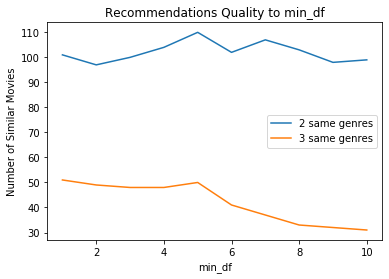

In [0]:
import matplotlib.pyplot as plt

length_2 = []
length_3 = []
min_dfs = [1,2,3,4,5,6,7,8,9,10]
for min_df in min_dfs:
  corpus_tf_idf = tf_idf(1.0, min_df, names)
  temp = []
  length_2.append(len(similar_movies(2)))
  length_3.append(len(similar_movies(3)))
  

plt.plot(min_dfs, length_2)
plt.plot(min_dfs, length_3)
plt.xlabel('min_df')
plt.ylabel('Number of Similar Movies')
plt.title('Recommendations Quality to min_df')
plt.legend(['2 same genres', '3 same genres'], loc='center right')
plt.show()

In [0]:
print(length_2)
print(length_3)

[101, 97, 100, 104, 110, 102, 107, 103, 98, 99]
[51, 49, 48, 48, 50, 41, 37, 33, 32, 31]


Παρατηρούμε γενικά μείωση της ποιότητας των επιλογών με την αύξηση του min_df, με μία μικρή αύξηση όμως στις τιμές για count = 2 και min_df μεταξύ 4 και 8. Για count = 3 παρατηρείται μείωση της ποιότητας. Έτσι οι παρατηρήσεις μας επιβεβαιώνονται.

Συνεπώς θεωρούμε μια μέση καλή επιλογή την min_df = 6, η οποία διατηρεί την ποιότητα και μειώνει τη διαστατικότητα στις 10549 από τις 45254, δηλαδή μείωση κατά 76.7%.

### 10 Πετυχημένες Επιλογές

In [33]:
corpus_tf_idf = tf_idf(1.0, 6, names)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Dimensions:  (5000, 10549) 



1.Οι ταινίες αφορούν τους Stooges, 3 άντρες, οι οποίοι ξεκινώντας σε κάθε ταινία από διαφορετικό εργασιακό backround καταφέρνουν να μπλεχθούν σε αστείες ιστορίες.

In [34]:
content_recommender(12, 6)

ID:  12
Title:  Monkey Businessmen
Categories:  "Short Film",  "Comedy",  "Black-and-white",  "Slapstick"
Summary:
 The Stooges are inept electricians who manage to electrocute themselves as well as their boss, "Smilin'" Sam McGann . After predictably getting fired from their job, Curly suggests that the boys take "a nice, long rest." They spot an ad for Mallard's Rest Home, and embark on their R&R trip. Upon arrival, the boys are introduced to Dr. Mallard ([[Kenneth MacDonald  who prescribes a detailed, regimented schedule of exercise, only to be fed a "nice bowl of milk" for breakfast and lunch. Mallard then assigns two nurses to train the Stooges, which sends the boys head over heels into fits of love — until the nurses turn out to be men . While the Stooges are vigorously training in the gym the following day, Moe and Larry attempt to help Curly flex his muscles by removing the individual weights, pound by pound. The weights land on the nurses' heads, knocking them cold. In their d

2.Όλες οι ταινίες αφορούν σχέσεις παντρεμένων ανθρώπων. Οι λέξεις που κυριαρχούν είναι "marry", "affair" και "divorce".

In [35]:
content_recommender(1547, 5)

ID:  1547
Title:  The Divorcee
Categories:  "Pre-Code",  "Black-and-white",  "Drama",  "Film adaptation",  "Romantic drama",  "Romance Film"
Summary:
 Ted , Jerry , Paul  and Dorothy  are part of the New York in-crowd. Jerry's decision to marry Ted crushes Paul. He gets drunk and is involved in an accident that leaves Dorothy's face disfigured. Out of pity, Paul marries Dorothy. Ted and Jerry have been married three years when she discovers he had a brief affair with another woman — and when she confronts him on their third anniversary, he tells her it didn't "mean a thing". Lonely and upset, and with Ted out on a business trip, Jerry has an affair with his best friend, Don. She shares the truth with Ted upon his return, withholding Don's name, and they argue ending with Ted leaving her and the couple filing for a divorce. While Jerry turns to partying to drown her sorrows, Ted becomes an alcoholic. Paul and Jerry run into each other and she discovers he still loves her and is willing 

3.Και οι 5 ταινίες αφορούν τον κόσμο του εγκλήματος, είτε από την πλευρά των αστυνόμων είτε των δραστών και είτε το έγκλημα πρόκειται για δολοφονία είτε για κλοπή. Οι πρώτη αφορά μάλιστα τον ίδιο ήρωα, ενώ ο εντοπισμός της δεν έγινε μέσω του ονόματος, το οποίο όπως είπαμε έχει εξαιρεθεί, αλλά μέσω της πλοκής.

In [36]:
content_recommender(4814, 5)

ID:  4814
Title:  Jesse Stone: Innocents Lost
Categories:  "Crime Fiction",  "Thriller",  "Television movie",  "Drama",  "Film adaptation",  "Crime Thriller"
Summary:
 After being replaced as the chief of police in Paradise, Massachusetts by the town council president's son-in-law, William Butler , Jesse Stone is still without a full-time job . Nevertheless, he continues to find ways to pursue investigations into two separate murders: one involves a friend with whom he had lost contact, and the other has him working as a consulting investigator for the Massachusetts State Police Homicide Division on a case involving a robbery and murder suspect. Both Jesse and his friend, State Police Captain Healy , have doubts as to the robbery/murder suspect's guilt. All the while, Jesse deals with tensions between Butler, who expects him to give up his "concealed carry" gun permit, but who is informed, by Rose Gammon , that as a retired  police officer that he has a federally-mandated right to "con

4.Οι ταινίες έχουν κυρίως Ιάπωνες χαρακτήρες και σχετίζονται βασικά με τον Ιαπωνικό υπόκοσμο (Yakuza) και με τις διαμάχες που συμβαίνουν σε αυτό το πλαίσιο.

In [37]:
content_recommender(4912, 6)

ID:  4912
Title:  The Street Fighter
Categories:  "Action/Adventure",  "Action",  "Martial Arts Film",  "Japanese Movies",  "World cinema"
Summary:
 The film begins as Takuma  Tsurugi meets the condemned murderer Tateki  Shikenbaru while disguised as a Buddhist monk. Tsuguri applies his "oxygen coma punch" to Junjo, causing him to collapse just before he can be executed. As Junjo is rushed to a hospital, Tsurugi and his sidekick Rakuda  ambush the ambulance and free him. As Tsurugi and Ratnose watch the incident on the news, Junjo's brother Gijun and sister Nachi arrive and plead for more time to pay for Tsurugi's help. Outraged, Tsurugi refuses and attacks the siblings. Gijun is defenestrated when Tsurugi dodges a flying kick, and Nachi is sold into sexual slavery by Mutaguchi. Mutaguchi and his associates attempt to hire Tsurugi to kidnap Sarai, the daughter of a recently deceased oil tycoon. Tsurugi refuses after discovering that the gangsters are Yakuza. He escapes, but the Yakuza 

5.Όλες οι ταινίες έχουν σχέση με το φαγητό, κυρίως μέσω των εστιατορίων και αρκετές με τον ρομαντισμό που αναπτύσσεται σε αυτό το πλαίσιο μεταξύ ανθρώπων.

In [38]:
content_recommender(4953, 6)

ID:  4953
Title:  Bon Appétit
Categories:  "Romance Film",  "Drama",  "Comedy"
Summary:
 Daniel  is a young and ambitious Spanish chef who just realized his dream: working at a famous restaurant managed by star chef Thomas Wackerle . Due to his extraordinary talent, Daniel soon progresses in Wackerle's demanding kitchen. He is attracted to Hanna , the attractive sommellier of the restaurant. One evening, Daniel and Hanna are walking in the city, talking about life, love, and relationships. Daniel expresses his opinion that love isn't at all like a romantic movie. After saying this, Hanna kisses Daniel. This unexpected situation provides a turning point in Daniel's tidy and organized life. He faces a difficult question: Is it worth risking your professional career for love? Bon Appétit is a film telling the story of friends who dare to cross the thin line dividing friendship and romantic love. The film talks about conventional people and includes scenes shot in some of the most pictures

6.Οι ταινίες αφορούν πράκτορες, κυρίως της CIA (εκτός της 3ης επιλογής) και τις κατασκοπευτικές περιπέτειές τους.

In [39]:
content_recommender(60, 5)

ID:  60
Title:  History Is Made at Night
Categories:  "Thriller",  "Romantic comedy",  "Indie",  "Comedy",  "Romance Film",  "Action",  "Suspense"
Summary:
 Harry  is a seasoned CIA agent who is looking to forget his past and become his cover identity—a jazz club owner in Helsinki, Finland. Natasha  is a young, ambitious SVR agent who is looking to secure a future for herself amidst the chaos of the new Russian Republic and her floundering intelligence agency. Originally assigned to spy on Harry, Natasha has fallen in love with the object of her spying, and her assignment has led to a torrid love affair between the two. Like all couples, they are keeping secrets from each other—but in their case, the secrets have international implications. Harry's life with Natasha is disrupted when a young, over-zealous CIA agent, Dave , comes to Helsinki to intercept a videotape encoded with state secrets en route from New York. The videotape's hidden code is so sensitive that those who come in cont

7.Οι ταινίες έχουν πολεμικό χαρακτήρα, κυρίως το κομμάτι που αφορά τις πολεμικές αεροπορίες και οι περισσότερες το συνδυάζουν και με ρομαντικές σχέσεις μεταξύ των ηρώων.

In [40]:
content_recommender(103, 6)

ID:  103
Title:  Flyboys
Categories:  "Adventure",  "History",  "Action/Adventure",  "Period piece",  "Drama",  "War film",  "Romance Film",  "Action"
Summary:
 Prior to America's entrance into the war, a group of young Americans go to France, for different personal reasons, to fight in the French Air Service, L'Aéronautique militaire, during World War I . One of them, Blaine Rawlings  faced with the foreclosure of his family ranch in Texas, decides to enlist after seeing a newsreel of aerial combat in France. Dilettante Briggs Lowry  joins because of his overbearing father. African-American boxer Eugene Skinner , who had been accepted as an athlete in France, was motivated to "pay back" his adopted country. These American recruits were under the command of French Captain Georges Thenault , while the veteran fighter ace Reed Cassidy , a fellow American, takes over as their mentor. During their training, each pilot struggles with the demanding flying; later, they have to face the aerial

8.Οι ταινίες είναι όλες western, διαδραματίζονται στα ίδια μέρη στις Νότιες και Δυτικές Η.Π.Α. και υπάρχουν κοινές λέξεις όπως "Indians", "Cowboy" και "Horse". 

In [41]:
content_recommender(248, 6)

ID:  248
Title:  The Stalking Moon
Categories:  "Action/Adventure",  "Western",  "Action",  "Indian Western"
Summary:
 U.S. Army soldiers round up a group of Indians, mostly women and children. Surprisingly, they find among them a white woman and her half-Indian son. Sam Varner  is a scout retiring from the Army to his ranch in New Mexico. He agrees to escort Sarah Carver  and her son after she begs him. She wants to leave immediately rather than wait five days for a military escort. Varner takes them to a stage coach stop called Hennessy. The boy runs away during the night. Varner and Sarah go looking for him as a dust storm begins. They find the boy and then hole up  to wait out the storm. When they return to the station, everyone there is dead, killed by the boy's Indian warrior father, Salvaje . Salvaje is greatly feared even among his own people - and with good reason: he is known to be a silent and ruthless killer. Salvaje means "Ghost" in Apache, or in their own tongue: "He Who 

9.Όλες οι ταινίες παρουσιάζουν ρομαντικές σχέσεις μεταξύ ανθρώπων κυριώς στον χώρο του πανεπιστημίου.

In [42]:
content_recommender(749, 5)

ID:  749
Title:  Arya
Categories:  "Romantic comedy",  "World cinema",  "Musical",  "Drama",  "Comedy",  "Tollywood",  "Romantic drama",  "Romance Film"
Summary:
 Geetanjali a.k.a. Geeta  goes to Kanyakumari on a trip. She finds a poem in a diary left on a beach and signs in it. Her anklet falls into the ocean and a guy jumps into the water in front of her eyes but no one sees him resurfacing. However, Geeta did not see who jumped in the ocean. She dreams about the incident frequently with the idea that the guy who jumped has died but her friends ask her to forget it. Ajay  is a spoiled brat, and is the son of local MP Avataram . He likes to flirt with beautiful girls and wants them to be his girlfriends. One day he sees Geeta and proposes to her. When she refuses, he threatens to jump from the top of college building. Being a weak-minded girl, Geeta accepts the proposal with the thought that as some guy has already died for her and she doesn't want someone to get hurt because of her a

10.Όλες οι ταινίες αφορούν εγκλήματα και παρουσιάζονται είτε οι εγκληματικές προσωπικότητες είτε όσοι προσπαθούν να τους οδηγήσουν στη δικαιοσύνη. Στις περισσότερες περιπτώσεις αυτό έχει και το χαρακτήρα εκδίκησης, όπως και στην ταινία-στόχο.



In [43]:
content_recommender(1446, 6)

ID:  1446
Title:  Underworld U.S.A.
Categories:  "Thriller",  "Crime Fiction",  "Black-and-white",  "Drama",  "Crime Thriller",  "Action",  "Film noir"
Summary:
 Fourteen-year-old Tolly Devlin sees four hoods beat his father to death. Twenty years later, the killers have risen to the top of the crime syndicate. Ever since his adolescence, Tolly's  goal has been to avenge his father. Tolly has even become a criminal and gotten himself sent to prison so that he could get close to one of the perpetrators. Tolly becomes as vindictive and sadistic as the men he is after. He rejects the two relationships that could redeem him, his mother-figure  and his moll  in favor of cold, hard vengeance. Becoming a secret informant for the government, Tolly ends up playing both sides against the middle in his cagey campaign to bring down the remaining mobsters. Tolly's nihilistic vendetta eventually robs him of his own humanity . 

Place: 1
ID:  1687
Title:  Fast Getaway
Categories:  "Crime Fiction",  "

## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Προσοχή: αυτό ισχύει μόνο στα Azure και Kaggle, στο Colab και στο IBM τα αρχεία εξαφανίζονται όταν ανακυκλώνεται ο πυρήνας και θα πρέπει να τα αποθηκεύετε τοπικά. Περισσότερα στο [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing).

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [44]:

import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl', compress=True) 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [45]:
!ls -lh

total 23M
-rw-r--r-- 1 root root 3.8M Jan 26 19:17 corpus_tf_idf.pkl
drwxr-xr-x 1 root root 4.0K Jan 13 16:38 sample_data
-rw-r--r-- 1 root root  19M Jan 26 19:17 som20x20@100e.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [0]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

Σημειώστε ότι το IBM Watson δείνει "Kernel dead" εάν δεν έχετε βελτιστοποιήσει το tfidf και μικρύνει τις διαστάσεις του dataset (πιθανότατα κάποια υπέρβαση μνήμης).

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [49]:
print(corpus_tf_idf.shape)
print(final_set.shape)

(5000, 10549)
(5000, 10871)


Τυπωνουμε τις (μη μηδενικες) τιμες ενος στοιχειου του final_set για να δουμε τι περιεχει. 

In [50]:
for i in range(len(final_set[0])):
    if final_set[0][i]!=0:
        print(final_set[0][i])

0.27258533
0.24095662
0.27112398
0.11362487
0.37087595
0.22564878
0.20655349
0.66298616
0.1673673
0.1528951
0.24320422
1.0


Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

Θα μπορούσε να εφαρμοστεί PCA για την περαιτέρω μείωση της διαστατικότητας πριν εκπαιδεύσουμε τον χάρτη SOM. Στο πρώτο εργαστήριο η εφαρμογή PCA ήταν αυτή που βελτιώνε τα αποτελέσματα περισσότερο από όλες τις άλλες μεθόδους.

## Εκπαίδευση χάρτη SOM




Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [53]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 8.6 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5-cp36-cp36m-linux_x86_64.whl size=419255 sha256=c7780143aa01bdbb4611f97e97ebb1895344c2b0ebd60f617600e809736c10df
  Stored in directory: /root/.cache/pip/wheels/9f/f0/00/215f76b550c8f69ace8bea4828c7823b43552e10ba9b4a16f2
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


Αρχικα οριζουμε τις διαστασεις του SOM για να τις εχουμε ευκαιρες, και οριζουμε το ονομα του αρχειου που ειτε θα αποθηκευσουμε στην συνεχεια η (στους υπολογιστες μας) θα φορτωσουμε για να μην κανουμε την εκπαιδευση του δικτυου.

In [0]:
n_rows, n_columns = 20,20
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = 'som' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'

In [0]:
som = joblib.load(filename)

In [0]:
%time som.train(final_set, epochs=epochs)


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


Για να καταλαβουμε την φυση των δεδομενων, τυπωνουμε αρχικα τις διαστασεις του πινακα με τα bmus, και ενδεικτικα καποια απο αυτα για να δουμε τι συμβαινει:

In [69]:
bmus = som.bmus
print(bmus.shape)
print(bmus)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices

(5000, 2)
[[ 3 13]
 [16 12]
 [10 17]
 ...
 [17  0]
 [19 17]
 [16 10]]


Επιπλεον, τυπωνουμε τα ιδια για τα ubmus. Παρατηρουμε οτι δεν υπαρχουν ολοι οι νευρωνες, δηλαδη σε καποιους νευρωνες δεν εχουν ανατεθει ταινιες (π.χ. ο νευρωνας (1,5)).

In [70]:
print(ubmus.shape)
print(ubmus)

(332, 2)
[[ 0  0]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  5]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  5]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 5  0]
 [ 5  1]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  9]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 5 15]
 [ 5 16]
 [ 5 18]
 [ 5 19]
 [ 6  0]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  6]
 [ 6 10]
 

In [71]:
print(len(indices))
print(indices)

5000
[ 65 272 175 ... 279 329 270]


Κανουμε χρηση της np.where για να δουμε την μορφη εξοδου, αλλα και για να δουμε οτι ολα δουλευουν σωστα.

In [72]:
print(np.where(indices==0))

(array([ 130,  226,  320,  330,  593,  596,  618,  676,  966, 1080, 1276,
       1366, 1398, 1407, 1448, 1457, 1464, 1584, 1585, 1662, 1977, 2034,
       2281, 2380, 2507, 2526, 2732, 2744, 2876, 2889, 2986, 3022, 3048,
       3248, 3276, 3438, 3451, 3562, 3565, 3652, 3658, 3666, 3685, 3823,
       4101, 4116, 4265, 4347, 4351, 4352, 4466, 4609, 4641, 4710, 4724,
       4733, 4887, 4927]),)



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [0]:
from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=25)
som.cluster(algorithm=algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [0]:
filename = 'som' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'
joblib.dump(som, filename, compress = True)

['som20x20@100e.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



Χρησιμοποιουμε τις παραπανω πληροφοριες για να τυπωσουμε το heatmap και τους πινακες ετσι ωστε να εχουμε μια καλυτερη εικονα.

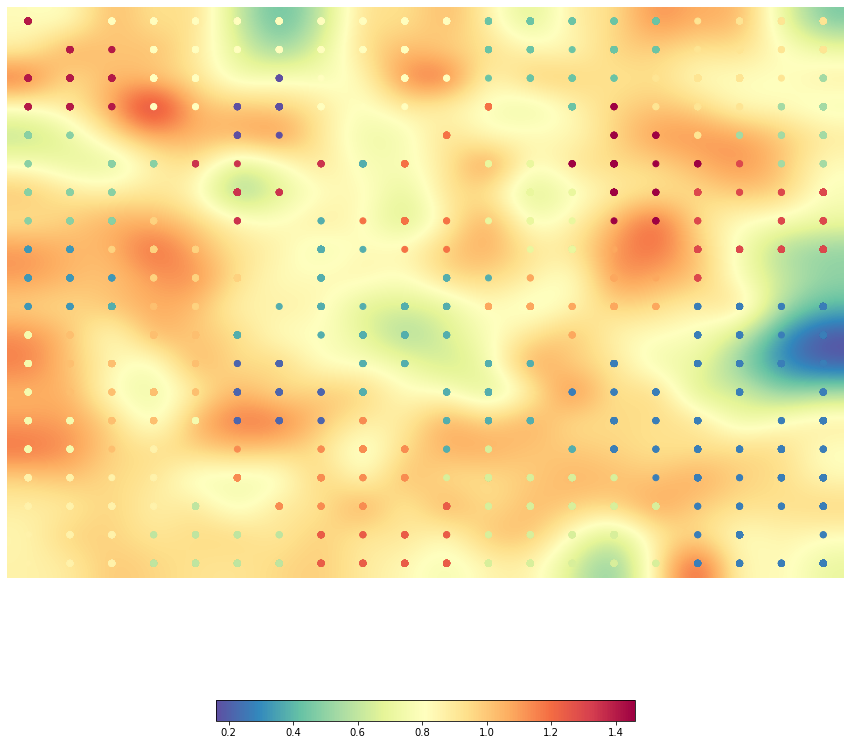

[[23 23 12 12 12 12 12 12 12 12 12  5  5  5  5  5 14 14 14 14]
 [23 23 23 12 12 12 12 12 12 12 12  5  5  5  5  5 14 14 14 14]
 [23 23 23 12 12 12  0 12 12 12 12  5  5  5  5 14 14 14 14  7]
 [23 23 23 12 12  0  0 12 12 12 19 19  5  5 24 14 14 14  7  7]
 [ 6  6  6  6 22  0  0 12 12 19 19 19 10 24 24 24 14  7  7  7]
 [ 6  6  6  6 22 22 22 22  4 19 19 10 10 24 24 24 24 21  7  7]
 [ 6  6  6  6 22 22 22 22  4 19 19 10 10 10 24 24 21 21 21 21]
 [ 6  6  6 15 15 22 22  4 19 19 19 10 10 10 24 24 21 21 21 21]
 [ 3  3 15 15 15 15  4  4  4 19 19  4 10 10 17 21 21 21 21 21]
 [ 3  3  3 15 15 15  4  4  4  4  4  4 17 17 17 17 21 21 21 21]
 [ 3  3  4 16 15 15  4  4  4  4  4 17 17 17 17 17  2  2  2  2]
 [11 16 16 16 16  4  4  4  4  4  4  4 17 17 17  2  2  2  2  2]
 [11 16 16 16 16  1  1  1  4  4  4  4  4  2  2  2  2  2  2  2]
 [11 16 16 16 16  1  1  1  4  4  4  4  4  2  2  2  2  2  2  2]
 [11 11 16 16 11  1  1  1 18 18  4  4  4  2  2  2  2  2  2  2]
 [11 11 16 13 13 18  1 18 18 18  4  9  4  4  2  2  2  2

In [93]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

Αρχικα ορισαμε την πρωτη συναρτηση, η οποια παιρνει μια λιστα με ταινιες (list of ints) και τυπωνει τον αριθμο των μοναδικων κατηγοριων (κατηγοριες που εμφανιζονται στην λιστα αυτη με τις ταινιες), καθως και για την καθε κατηγορια τον αριθμο των ταινιων που εχουν σαν κατηγορια αυτην. 

In [0]:
#Imported counter to count unique categories
from collections import Counter
#Imported operator to have a rule of ordering based on the second item of a tuple
import operator

def print_categories_stats(movie_list):
    
    #create the empty list
    total_categories = []
    
    for movie in movie_list:
    
        #take the categories of the string (its a list of one string, so take the first element)
        cats = categories[movie][0]
        #split on comma
        cats = cats.split(',')
    
        for cat in cats:
            #strip of extra spaces
            cat = cat.strip(' ')
            #strip of quotes
            cat = cat.strip('"')
            #put it on the list
            total_categories.append(cat)
    
    #use the counter module to get the unique names of the categories
    uniq = list(Counter(total_categories).keys())
    #as well as the indices of the categories themselves:
    indices = list(Counter(total_categories).values())


    #this didn't work correctly:
    #uniq, indices = np.unique(total_categories, return_index=True)
    
    
    print("Overall Genre Stats:")
    tots = []
    for i in range(len(uniq)):
        tots.append((uniq[i], indices[i]))
    print(len(tots), "Categories.")

    #sort based on the second item of the tuples in tots. 
    tots.sort(key = operator.itemgetter(1), reverse=True)
    print(tots)
    return 0

Για να το τεσταρουμε, χρησιμοποιουμε σαν εισοδο την πληρη λιστα ταινιων (φτιαξαμε μια λιστα με 5000 αριθμους):

In [65]:
movie_list_ids = list(range(5000))
print_categories_stats(movie_list_ids)

Overall Genre Stats:
272 Categories.
[('Drama', 2302), ('Comedy', 1240), ('Romance Film', 778), ('Thriller', 771), ('Action', 703), ('World cinema', 605), ('Crime Fiction', 496), ('Horror', 496), ('Black-and-white', 462), ('Short Film', 428), ('Family Film', 407), ('Action/Adventure', 406), ('Adventure', 396), ('Indie', 362), ('Musical', 317), ('Animation', 288), ('Science Fiction', 285), ('Romantic drama', 285), ('Mystery', 254), ('Romantic comedy', 250), ('Fantasy', 232), ('Comedy film', 227), ('Crime Thriller', 186), ('War film', 177), ('Japanese Movies', 151), ('Silent film', 147), ('Psychological thriller', 146), ('Comedy-drama', 142), ('Bollywood', 138), ('Period piece', 136), ('Film adaptation', 130), ('Documentary', 121), ('Western', 116), ('Chinese Movies', 105), ('Coming of age', 97), ('Teen', 95), ('Television movie', 90), ('Parody', 90), ('Cult', 84), ('Black comedy', 83), ("Children's/Family", 81), ('Suspense', 80), ('Family Drama', 78), ('Slapstick', 76), ('Sports', 76), 

0

Στην συνεχεια ορισαμε την δευτερη συναρτηση, η οποια παιρνει εναν αριθμο που ειναι το id του cluster και επιστρεφει μια λιστα με αριθμους, που ειναι οι συντεταγμενες των νευρωνων για να βρουμε μεσω των bmus τις ταινιες που θα χρησιμοποιησουμε σαν ορισμα για την πρωτη συναρτηση. 

In [0]:
def print_cluster_neurons_movies_report(cluster_id):

    #use the previously built in variable 
    how_many_neurons = no_of_neurons[cluster_id]

    #use np.where to find where in the cluster map the value of the map is the same as the cluster id
    positions = np.where(som.clusters==cluster_id)
    #make a stack out of the tuples of the coordinates:
    pos = np.column_stack((positions[0], positions[1]))
    
    #create a list of indices to be returned
    INDICES = []
    for position in pos:
        if position in ubmus:
            #make sure the unique index is calculated correctly:
            INDICES.append(int(position[0])*n_rows + int(position[1]))
    return INDICES

Για να ελεγξουμε την ορθη λειτουργια της συναρτησης, την καλουμε με ορισμα 7 (που αντιστοιχει σε ενα cluster που ξερουμε τον αριθμο των νευρωνων που του αντιστοιχουν απο το cluster map):

In [95]:
print_cluster_neurons_movies_report(7)

[59, 78, 79, 97, 98, 99, 118, 119]

In [0]:
def neuron_movies_report(neuron_list):
    movie_list_IDs = []
    for neuron in neuron_list:
        list_of_movies = list(np.where(indices==neuron))
        for i in range(len(list_of_movies[0])):
            movie_list_IDs.append(list_of_movies[0][i])
    print_categories_stats(movie_list_IDs)

In [94]:
for i in range(25):
    neuron_movies_report(print_cluster_neurons_movies_report(i))

Overall Genre Stats:
56 Categories.
[('Action', 59), ('Crime Fiction', 48), ('Thriller', 42), ('Drama', 42), ('Crime Thriller', 33), ('Adventure', 28), ('Black-and-white', 18), ('Film noir', 17), ('Indie', 9), ('Crime Drama', 8), ('Film adaptation', 8), ('World cinema', 7), ('Romance Film', 6), ('Suspense', 6), ('Psychological thriller', 6), ('War film', 5), ('Gangster Film', 5), ('Historical fiction', 3), ('Jungle Film', 3), ('Period piece', 3), ('Martial Arts Film', 3), ('Sports', 3), ('Costume Adventure', 2), ('Action Thrillers', 2), ('Bollywood', 2), ('Family Film', 2), ('Television movie', 2), ('Comedy film', 2), ('Neo-noir', 2), ('Courtroom Drama', 2), ('Romantic drama', 2), ('Comedy-drama', 1), ('Wuxia', 1), ('Chinese Movies', 1), ('Western', 1), ('Costume drama', 1), ('Action/Adventure', 1), ('Spy', 1), ('Action Comedy', 1), ("Children's/Family", 1), ('Tamil cinema', 1), ('Sci Fi Pictures original films', 1), ('Fantasy', 1), ('Feature film', 1), ('Mystery', 1), ('Black comedy',


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο mycourses το παρόν notebook επεξεργασμένο με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Προσέξτε ώστε να **απαντήσετε σε όλα τα σημεία όπου απαιτείται**.
- Μαζί Θα παραδώσετε τα joblib dumps των τελικών `corpus_tf_idf.pkl` και `som.pkl` (μεγάλος χάρτης - 5000 ταινίες) που θα χρησιμοποιήσετε. Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στο dump του χάρτη που θα μας παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. Οδηγίες για την αποθήκευση των dumps θα βρείτε στο [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing). 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.
- Στο **zip** που θα παραδώσετε πρέπει να βρίσκονται **4 αρχεία (το .ipynb και το .py του notebook καθώς και τα δύο .pkl)**
- **Το maximum upload filesize στο mycourses είναι 29MB**, εάν το zip σας είναι μεγαλύτερο, δεν έχετε βελτιστοποιήσει το tfidf.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!</font>
</td>
  </tr>
</table>

## Ημερομηνία παράδοσης ##

Κυριακή 19 Ιανουαρίου 2020.

Καλή επιτυχία!
